This notebook studies a dataset of frauds in credit card transactions and creates a model that identifies a suspect transaction.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from tabulate import tabulate
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Load dataset

The 'Time' column indicates the moment when the transaction was made, that is, it is a metadata and should not be used in the model.


In [2]:
df_train = pd.read_csv('train.csv', sep=',', decimal='.').drop('Time', axis=1)
df_test = pd.read_csv('test.csv', sep=',', decimal='.').drop('Time', axis=1)
df = pd.concat([df_test, df_train])
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.439952,0.683758,1.225814,0.639113,0.716765,0.089295,0.657718,0.034213,-0.472679,0.352698,...,0.127443,0.588590,-0.145728,-0.322900,-0.299744,-0.310295,0.248317,-0.011493,19.00,0
1,-4.868108,1.264420,-5.167885,3.193648,-3.045621,-2.096166,-6.445610,2.422536,-3.214055,-8.745973,...,1.269205,0.057657,0.629307,-0.168432,0.443744,0.276539,1.441274,-0.127944,12.31,1
2,1.013114,-0.334412,1.305208,0.837406,-1.126833,-0.064321,-0.594753,0.147737,0.536360,-0.120472,...,0.017079,0.112210,-0.016084,0.595033,0.201073,0.278215,0.007457,0.030762,66.60,0
3,0.969231,-0.233554,0.238473,0.145793,-0.545741,-0.970680,0.347393,-0.209522,-0.342571,-0.100331,...,-0.362820,-1.417272,0.162136,0.541628,-0.079465,0.268702,-0.101237,0.028234,141.00,0
4,-0.856523,1.080875,1.866956,1.729941,-0.161741,0.028789,0.401787,0.043774,-0.213916,0.155907,...,0.007365,0.077392,-0.221906,0.394141,0.237225,-0.080102,-0.291408,0.092140,2.60,0


In [3]:
X_train = df_train.drop(['Class'], axis=1)
y_train = df_train['Class']

X_test = df_test.drop(['Class'], axis=1)
y_test = df_test['Class']

# Dataset study

The answer variable is the column 'Class', with 1 representing a fraud and 0 a legal transaction.

<Axes: xlabel='Class', ylabel='Count'>

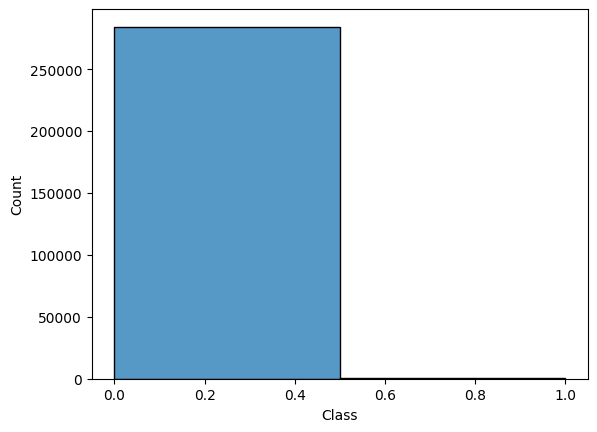

In [4]:
sns.histplot(data=df, x='Class', bins=2)

In [5]:
frauds = (df['Class'].values == 1).sum()
frauds = 100 * frauds / df.shape[0]
print(f"Porcentage of frauds: {round(frauds, 2)}%")
print(f"Porcentage of non frauds: {100 - round(frauds, 2)}%")

Porcentage of frauds: 0.17%
Porcentage of non frauds: 99.83%


As the great majority of transactions are not fraudulent, this dataset is not balanced, and the used metric should be chosen with that in mind.

# AUC and Accuracy metrics

To test the [AUC-ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and accuracy metrics, let's define 3 different models, one that predicts every transaction to be fraudulent, one that predicts every transaction to be non-fraudulent and one that predicts each transaction to be fraudulent with a 50% change.

In [6]:
y = df_test['Class'].to_numpy()
model_fraud = np.ones(y.shape[0])
model_non_fraud = np.zeros(y.shape[0])
model_random = np.random.binomial(size=y.shape[0], p=0.5, n=1)

acc_fraud = accuracy_score(y, model_fraud)
acc_non_fraud = accuracy_score(y, model_non_fraud)
acc_random = accuracy_score(y, model_random)

auc_fraud = roc_auc_score(y, model_fraud)
auc_non_fraud = roc_auc_score(y, model_non_fraud)
auc_random = roc_auc_score(y, model_random)

In [7]:
table = [['',        'Random',    'Always fraud',   'Never fraud'], 
         ['Accuracy', acc_random, acc_fraud,        acc_non_fraud], 
         ['AUC',      auc_random, auc_fraud,        auc_non_fraud]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign="center"))

╒══════════╤══════════╤════════════════╤═══════════════╕
│          │  Random  │  Always fraud  │  Never fraud  │
╞══════════╪══════════╪════════════════╪═══════════════╡
│ Accuracy │ 0.497714 │   0.00156598   │   0.998434    │
├──────────┼──────────┼────────────────┼───────────────┤
│ AUC      │ 0.486543 │      0.5       │      0.5      │
╘══════════╧══════════╧════════════════╧═══════════════╛


All 3 models are bad, so the metrics should reflect this. Since the accuracy metric gives a good score to the model that predicts all transactions to be non-fraudulent, it is not a good metric to use in this unbalanced dataset. Therefore, we will use the AUC-ROC metric in this notebook.

# Define and train classificator

Let's test some parameters and determine the best combination for this case.

With the hiperparameter 'class_weight' as 'balanced', the database rows will have weight inverselly proportional to the frequency of its answer variable in the dataset, that is, the fraudulent transactions will have a bigger impact in the model.

In [8]:
parameters = {'n_estimators':[10, 50, 100], 'max_depth':[3, 4, 5]}

In [9]:
rfc = RandomForestClassifier(class_weight='balanced') 
grid = GridSearchCV(estimator = rfc,          
                    param_grid = parameters,  
                    scoring = 'roc_auc',           
                    cv = 3) 

In [10]:
grid.fit(X_train, y_train)
pd.DataFrame(grid.cv_results_)[['params','rank_test_score','mean_test_score']]

,params,rank_test_score,mean_test_score
0,"{'max_depth': 3, 'n_estimators': 10}",3,0.973151
1,"{'max_depth': 3, 'n_estimators': 50}",1,0.975011
2,"{'max_depth': 3, 'n_estimators': 100}",4,0.972889
3,"{'max_depth': 4, 'n_estimators': 10}",6,0.971981
4,"{'max_depth': 4, 'n_estimators': 50}",8,0.969085
5,"{'max_depth': 4, 'n_estimators': 100}",2,0.975010
6,"{'max_depth': 5, 'n_estimators': 10}",9,0.962852
7,"{'max_depth': 5, 'n_estimators': 50}",7,0.971336
8,"{'max_depth': 5, 'n_estimators': 100}",5,0.972727


Therefore, the best tested parameters combination is max_depth = 3 and n_estimators = 50.

# Test the classifier

Let's test the classifier assuming that: the top 1% of transactions identified as frauds by the classifier will be blocked, each fraud avoided generates $\$$ 100 in profit and each non-fraudulent transaction blocked generates a loss of $\$$ 2.

In [11]:
predictions = grid.predict_proba(X_test)

# Concatenate prediction and answers to sort and maintein relation
comparasion = np.insert(predictions, 0, y_test, axis=1)

# Sort and take the top 1% more likely to be frauds
comparasion = comparasion[comparasion[:, 2].argsort()[::-1]]
blocked_transactions = comparasion[0:comparasion.shape[0]//100]

net_gain = 0
for transaction in blocked_transactions:
  if transaction[0] == 1: 
    net_gain += 100
  else:
    net_gain -= 2

print(f"The net gain in this cenario would be ${net_gain}")

The net gain in this cenario would be $16940
